In [1]:
###############################
#  GoogleNet Inception V3 with pretrained
###############################

import numpy as np
import pandas as pd
import gc
import csv

import warnings
warnings.filterwarnings('ignore')

import os
import datetime
import time
import glob
import os.path as osp
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils import data as D
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from tensorboardX import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print("total GPU: %d" %(torch.cuda.device_count()))



cuda:0
total GPU: 2


In [2]:
###############################
# path to dataset
###############################
class DefaultConfig(object):
    env = 'default' # visdom 环境
    path = '../data/compcars/data/cropped_image/'   #../data/compcars/data/image
    labelPath = '../data/compcars/data/label/'
    miscPath = '../data/compcars/data/misc/'
    modleNameFile = '../data/compcars/data/misc/modle_names.csv'
    makeNameFile = '../data/compcars/data/misc/make_names.csv'
    trainFilename = '../data/compcars/data/train_test_split/classification/train.txt'
    testFilename = '../data/compcars/data/train_test_split/classification/test.txt'
    log_dir = '../log/'
    num_workers = 8
    num_epoches = 100
    lr = 0.1
    lr_decay = 0.95
    max_epoch = 200000
    weight_decay = 1e-4
    load_model_path = '../checkpoints/train.pth'
    previous_loss = 1e100
    modle_csv_file = 'modle_names.csv'

opt = DefaultConfig()

logger = SummaryWriter(opt.log_dir, flush_secs=2)

In [3]:
##############################
# calculate the features size from paper's training dataset
##############################
paperTrainFeatureSet = set()
with open(opt.trainFilename, newline='\n') as trainfile:
            for line in trainfile:
                feature = line.split('/')[1]
                paperTrainFeatureSet.add(feature)
print('total train feature size: %s' %(len(paperTrainFeatureSet)))
num_classes = len(paperTrainFeatureSet)
paperTrainFeatureList = sorted(paperTrainFeatureSet)
featureIndex = paperTrainFeatureList.index('104')
print(featureIndex)

compcarsFeatures = {}
modle_csv = os.path.join(opt.miscPath, opt.modle_csv_file)
with open(modle_csv, newline='\n') as modlefile:
    for line in modlefile:
        items = line.split(',')
        key, values = items[0], items[1]
        compcarsFeatures[key] = values

print('total compcars dataset feature size:', len(compcarsFeatures))


total train feature size: 431
12
total compcars dataset feature size: 2004


In [5]:
###############################
#  dataset transform class
###############################
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)


class CompcarsDS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, root, mode='train'):
        """ Intialize the dataset
        """
        self.filenames = []
        self.root = root
        if mode == 'train':
            self.transform = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.Scale(299),
                transforms.CenterCrop(299), 
                transforms.ToTensor(),
                normalize
            ])
        if mode == 'valid':
            self.transform = transforms.Compose([
                transforms.Scale(299),
                transforms.CenterCrop(299), 
                transforms.ToTensor(),
                normalize
            ])
                    
        # below for train dataset selected by the paper
        with open(opt.trainFilename, newline='\n') as trainfile:
            for line in trainfile:
                self.filenames.append(opt.path + line.replace("\n",""))
        
        self.len = len(self.filenames)
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = Image.open(self.filenames[index])
        labelStr = self.filenames[index].split("/")[6]
        label = paperTrainFeatureList.index(labelStr)
        return self.transform(image), label
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

 

myCompcars = CompcarsDS(opt.path)
print(myCompcars.len) 


    

16016


In [6]:
###############################
# Train set and Valid set 
###############################

train_len = int(0.7*myCompcars.len)
valid_len = myCompcars.len - train_len
train, valid = D.random_split(myCompcars, lengths=[train_len, valid_len])

trainloader = D.DataLoader(train, batch_size=80, shuffle=True, num_workers=8, pin_memory=True)
validloader = D.DataLoader(valid, batch_size=80, shuffle=True, num_workers=8, pin_memory=True)

dloaders = {'train':trainloader, 'valid':validloader}

print("train size: %d, valid size %d, lr: %.5f " %(len(train), len(valid), opt.lr))



train size: 11211, valid size 4805, lr: 0.10000 


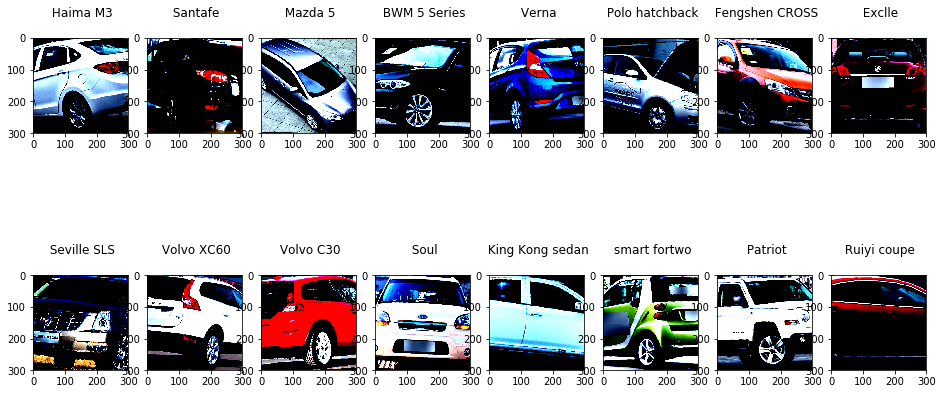

In [7]:
###############################
#  display some example dataset
###############################

# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(myCompcars, batch_size=16, shuffle=True, num_workers=opt.num_workers)

# functions to show an image
def imshow1(img, label):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def imshow2(imgs, labels, batch_size):
    for i in range(0, batch_size):
        npimg = imgs[i].numpy()
        label = labels[i].item()
        labelModel = compcarsFeatures[paperTrainFeatureList[label]]
        fig.add_subplot(2, 8, i + 1)
        plt.title(labelModel)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))   
        
    
# get some images
dataiter = iter(loader)
images, labels = dataiter.next()

with open(opt.modleNameFile, newline='') as modlefile:
    reader = csv.reader(modlefile)
    modleName = dict(reader)  
    
with open(opt.makeNameFile, newline='') as makefile:
    reader = csv.reader(makefile)
    makeName = dict(reader)    

# # show images
fig = plt.figure(figsize=(16, 8))
imshow2(images, labels, 16)



In [8]:
##################
#   below for GoogleNet Inception V3 
##################

# Load the model 
model_inception3 = torchvision.models.inception_v3(pretrained='imagenet')
net = model_inception3

# Freeze layers, only train FC
# (Futrure work)


# modify output classes
num_ftrs = net.fc.in_features                      #num_ftrs = 2048
net.fc = torch.nn.Linear(num_ftrs, num_classes)    

if torch.cuda.device_count() > 1:
    net = torch.nn.DataParallel(net)
   
net.cuda()

criterion = torch.nn.CrossEntropyLoss()
criterion.cuda()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
my_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [9]:
###############################
# load previous save model
###############################

# Load the model 
continue_model_inception3 = torchvision.models.inception_v3(pretrained=None)
net = continue_model_inception3

# # # modify output classes
num_ftrs = net.fc.in_features
net.fc = torch.nn.Linear(num_ftrs, num_classes)    #num_ftrs = 2048

criterion = torch.nn.CrossEntropyLoss()
criterion.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

checkpoint = torch.load(opt.load_model_path)
net.load_state_dict(checkpoint['model_state_dict'])  
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
my_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


if torch.cuda.device_count() > 1:
    net = torch.nn.DataParallel(net)
net.cuda()

print("done")


done


In [9]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=10000):
    since = time.time()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}
    print("train and valid sizes %d %d" %(len(dataloders['train'].dataset), len(dataloders['valid'].dataset)))
    for epoch in range(num_epochs):
        epoc_time = time.time()
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            
            if phase == 'train':
                train_running_corrects = 0
            else:
                valid_running_corrects = 0

            for inputs, labels in dataloders[phase]:
                t1 = time.time()
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

                optimizer.zero_grad()
                
                t2 = time.time()
                outputs = model(inputs)
                t3 = time.time()
                
                if phase == 'train':
                    loss1 = criterion(outputs[0], labels)
                    loss2 = criterion(outputs[1], labels)
                    loss = loss1 + loss2     #Future work, change to e.g. loss1 + 0.4 x loss2
                    preds = torch.max(outputs[0], 1)[1]
                    train_running_corrects += torch.sum(preds == labels.data)
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs.data, 1)
                    valid_running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                t4 = time.time()

                running_loss += loss.item()
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = train_running_corrects.double() / dataset_sizes[phase] * 100
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = valid_running_corrects.double() / dataset_sizes[phase] * 100 
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.module.state_dict()
                torch.save({
                   'epoch': epoch,
                   'epochTrainLoss': train_epoch_loss,
                   'epochValidLoss': valid_epoch_loss,
                   'epochTrainAcc': train_epoch_acc,
                   'epochValidAcc': valid_epoch_acc,
                   'model_state_dict':  model.module.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   }, opt.load_model_path)

        epocTotalTime = time.time() - epoc_time
        epocLoadDataTime = t2 - t1
        epocForwardTime = t3 - t2
        epocLossBackwardTime = t4 - t3
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f}% ' 
              'valid loss: {:.4f} acc: {:.4f}% Time: {:.0f}s train corr: {:d}  valid corr: {:d}  '.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc,
                (time.time() - epoc_time),
                train_running_corrects,
                valid_running_corrects 
              ))
        logger.add_scalar('Train/epocLoss', train_epoch_loss, epoch)
        logger.add_scalar('Train/accuracy', train_epoch_acc, epoch)
        logger.add_scalar('Valid/epocLoss', valid_epoch_loss, epoch)
        logger.add_scalar('Valid/accuracy', valid_epoch_acc, epoch)
        logger.add_scalar('Train/epocTotalTime', epocTotalTime, epoch)
        logger.add_scalar('Train/epocLoadDataTime', epocLoadDataTime , epoch)
        logger.add_scalar('Train/epocForwardTime', epocForwardTime, epoch)
        logger.add_scalar('Train/epocLossBackward', epocLossBackwardTime, epoch)
            
    
    print('Best val Acc: {:4f}'.format(best_acc))

    model_inception3 = torchvision.models.inception_v3(pretrained='imagenet')
    net = model_inception3
    num_ftrs = net.fc.in_features
    net.fc = torch.nn.Linear(num_ftrs, num_classes)    #num_ftrs = 2048
    net.load_state_dict(best_model_wts)
    net = torch.nn.DataParallel(net)
    net.cuda()
    
    
    return model


# InceptionV3 (only learn FC), 4 CPU, 2 GPU, 36G memory, 8 workers, batch size 160, lr = 0.001, pin_memroy = true,  epocTime: 112.507189 seconds
# InceptionV3 (only learn FC), 4 CPU, 2 GPU, 36G memory, 8 workers, batch size 320, lr = 0.001, pin_memroy = true,  epocTime: 121.634568 seconds
# InceptionV3 (only learn FC), 4 CPU, 2 GPU, 36G memory, 8 workers, batch size 320, lr = 0.1,   pin_memroy = true,  epocTime: 119.915348 seconds
# InceptionV3 (learn all), 4 CPU, 2 GPU, 36G memory, 8 workers, batch size 20, lr = 0.1,   pin_memroy = true,  epocTime:  280.700727 seconds
# InceptionV3 (learn all), 4 CPU, 2 GPU, 36G memory, 8 workers, batch size 100, lr = 0.1,   pin_memroy = true,  epocTime: ?   seconds  (GPU out of memory)
# InceptionV3 (learn all), 4 CPU, 2 GPU, 36G memory, 8 workers, batch size 80, lr = 0.1,   pin_memroy = true,  epocTime:  215.933716 seconds  
# train and valid sizes 8008 8008
# Epoch [0/99] train loss: 0.1567 acc: 0.0000% valid loss: 0.0747 acc: 0.0000% epocTime: 215.933716 seconds epoc_corrects: 66.000000
# Epoch [1/99] train loss: 0.1446 acc: 0.0000% valid loss: 0.0729 acc: 0.0000% epocTime: 212.573600 seconds epoc_corrects: 176.000000
# Epoch [2/99] train loss: 0.1163 acc: 0.0000% valid loss: 0.0675 acc: 0.0000% epocTime: 212.322831 seconds epoc_corrects: 359.000000
# Epoch [3/99] train loss: 0.0823 acc: 0.0000% valid loss: 0.0609 acc: 0.0000% epocTime: 212.074505 seconds epoc_corrects: 820.000000
# Epoch [4/99] train loss: 0.0584 acc: 0.0000% valid loss: 0.0530 acc: 0.0000% epocTime: 212.706546 seconds epoc_corrects: 1531.000000
# Epoch [5/99] train loss: 0.0424 acc: 0.0000% valid loss: 0.0448 acc: 0.0000% epocTime: 212.721654 seconds epoc_corrects: 2221.000000
# Epoch [6/99] train loss: 0.0313 acc: 0.0000% valid loss: 0.0411 acc: 0.0000% epocTime: 211.737994 seconds epoc_corrects: 2561.000000
# Epoch [7/99] train loss: 0.0223 acc: 0.0000% valid loss: 0.0365 acc: 0.0000% epocTime: 211.965657 seconds epoc_corrects: 3239.000000
# Epoch [8/99] train loss: 0.0197 acc: 0.0000% valid loss: 0.0359 acc: 0.0000% epocTime: 211.779382 seconds epoc_corrects: 3293.000000
# Epoch [9/99] train loss: 0.0184 acc: 0.0000% valid loss: 0.0355 acc: 0.0000% epocTime: 213.366607 seconds epoc_corrects: 3332.000000
# Epoch [10/99] train loss: 0.0171 acc: 0.0000% valid loss: 0.0348 acc: 0.0000% epocTime: 212.414871 seconds epoc_corrects: 3452.000000
# Epoch [11/99] train loss: 0.0162 acc: 0.0000% valid loss: 0.0346 acc: 0.0000% epocTime: 211.795254 seconds epoc_corrects: 3460.000000
# Epoch [12/99] train loss: 0.0153 acc: 0.0000% valid loss: 0.0341 acc: 0.0000% epocTime: 212.827844 seconds epoc_corrects: 3540.000000
# Epoch [13/99] train loss: 0.0146 acc: 0.0000% valid loss: 0.0339 acc: 0.0000% epocTime: 212.295064 seconds epoc_corrects: 3542.000000
# train and valid sizes 8008 8008 (50-50, batch size 100, no rotation, )
# Epoch [0/99] train loss: 0.1545 acc: 1.1489% valid loss: 0.0726 acc: 2.5724% epocTime: 215.505866s train_corr: 92.000000  valid_corr: 206.000000  
# Epoch [1/99] train loss: 0.1250 acc: 5.3696% valid loss: 0.0644 acc: 8.0794% epocTime: 212.381677s train_corr: 430.000000  valid_corr: 647.000000 

# train and valid sizes 11211 4805 (Inception3, Learn All, 70-30, batch size 100, rotation(30), )
# Epoch [0/99] train loss: 0.1449 acc: 1.0882% valid loss: 0.0733 acc: 2.2893% Time: 254s train corr: 122  valid corr: 110 
# Epoch [1/99] train loss: 0.1244 acc: 3.7106% valid loss: 0.0747 acc: 4.7451% Time: 256s train corr: 416  valid corr: 228
# Epoch [2/99] train loss: 0.0989 acc: 8.9912% valid loss: 0.0619 acc: 8.8450% Time: 255s train corr: 1008  valid corr: 425 
# Epoch [3/99] train loss: 0.0759 acc: 17.7058% valid loss: 0.0579 acc: 13.2570% Time: 255s train corr: 1985  valid corr: 637  
# Epoch [4/99] train loss: 0.0582 acc: 28.8823% valid loss: 0.0442 acc: 25.5567% Time: 255s train corr: 3238  valid corr: 1228  
# Epoch [5/99] train loss: 0.0442 acc: 39.9518% valid loss: 0.0391 acc: 32.8408% Time: 255s train corr: 4479  valid corr: 1578  
# Epoch [6/99] train loss: 0.0310 acc: 53.6705% valid loss: 0.0322 acc: 44.7451% Time: 254s train corr: 6017  valid corr: 2150
# Epoch [95/99] train loss: 0.0188 acc: 73.5974% valid loss: 0.0273 acc: 52.9657% Time: 254s train corr: 8251  valid corr: 2545  
# Epoch [96/99] train loss: 0.0190 acc: 72.8481% valid loss: 0.0270 acc: 52.2789% Time: 255s train corr: 8167  valid corr: 2512  
# Epoch [97/99] train loss: 0.0190 acc: 72.5181% valid loss: 0.0272 acc: 52.3205% Time: 255s train corr: 8130  valid corr: 2514  
# Epoch [98/99] train loss: 0.0190 acc: 73.0711% valid loss: 0.0275 acc: 52.0499% Time: 254s train corr: 8192  valid corr: 2501  
# Epoch [99/99] train loss: 0.0188 acc: 73.4457% valid loss: 0.0274 acc: 52.3621% Time: 255s train corr: 8234  valid corr: 2516  
# Best val Acc: 53.215401
# TensorIterator expected type torch.FloatTensor but got torch.cuda.FloatTensor[32, 3, 3, 3]
# train and valid sizes 11211 4805 (Inception3, Learn All, 70-30, batch size 100, rotation(10),  best accurary: 65.4% )
# Epoch [0/99] train loss: 0.1303 acc: 2.6581% valid loss: 0.0728 acc: 5.8065% Time: 254s train corr: 298  valid corr: 279 
# Epoch [0/99] train loss: 0.1303 acc: 2.6581% valid loss: 0.0728 acc: 5.8065% Time: 254s train corr: 298  valid corr: 279  
# Epoch [1/99] train loss: 0.0931 acc: 10.3559% valid loss: 0.0596 acc: 14.0479% Time: 255s train corr: 1161  valid corr: 675  
# Epoch [2/99] train loss: 0.0630 acc: 24.1102% valid loss: 0.0490 acc: 24.0791% Time: 256s train corr: 2703  valid corr: 1157  
# Epoch [3/99] train loss: 0.0432 acc: 38.1500% valid loss: 0.0387 acc: 34.0479% Time: 257s train corr: 4277  valid corr: 1636  
# Epoch [4/99] train loss: 0.0298 acc: 53.4921% valid loss: 0.0312 acc: 42.6847% Time: 255s train corr: 5997  valid corr: 2051  
# Epoch [5/99] train loss: 0.0210 acc: 65.6141% valid loss: 0.0277 acc: 51.3424% Time: 254s train corr: 7356  valid corr: 2467  
# Epoch [6/99] train loss: 0.0137 acc: 78.8244% valid loss: 0.0221 acc: 59.3965% Time: 255s train corr: 8837  valid corr: 2854  
# Epoch [7/99] train loss: 0.0117 acc: 83.0613% valid loss: 0.0208 acc: 61.8314% Time: 255s train corr: 9312  valid corr: 2971
# Epoch [8/99] train loss: 0.0108 acc: 85.2199% valid loss: 0.0204 acc: 62.7055% Time: 256s train corr: 9554  valid corr: 3013  
# Epoch [9/99] train loss: 0.0100 acc: 86.5400% valid loss: 0.0202 acc: 62.8928% Time: 254s train corr: 9702  valid corr: 3022  
# Epoch [10/99] train loss: 0.0093 acc: 88.4756% valid loss: 0.0197 acc: 63.7669% Time: 255s train corr: 9919  valid corr: 3064  
# Epoch [11/99] train loss: 0.0089 acc: 89.2070% valid loss: 0.0194 acc: 64.9324% Time: 255s train corr: 10001  valid corr: 3120  
# Epoch [12/99] train loss: 0.0083 acc: 90.3755% valid loss: 0.0196 acc: 63.9958% Time: 255s train corr: 10132  valid corr: 3075  
# Epoch [13/99] train loss: 0.0078 acc: 91.3478% valid loss: 0.0193 acc: 64.6618% Time: 254s train corr: 10241  valid corr: 3107
# Epoch [14/99] train loss: 0.0078 acc: 91.2407% valid loss: 0.0192 acc: 64.8491% Time: 255s train corr: 10229  valid corr: 3116  
# Epoch [15/99] train loss: 0.0078 acc: 90.8572% valid loss: 0.0192 acc: 64.3704% Time: 254s train corr: 10186  valid corr: 3093  
# Epoch [16/99] train loss: 0.0076 acc: 91.8473% valid loss: 0.0188 acc: 65.2445% Time: 256s train corr: 10297  valid corr: 3135  
# Epoch [17/99] train loss: 0.0076 acc: 91.5975% valid loss: 0.0190 acc: 65.0780% Time: 254s train corr: 10269  valid corr: 3127  
# Epoch [18/99] train loss: 0.0076 acc: 91.6332% valid loss: 0.0191 acc: 65.2237% Time: 254s train corr: 10273  valid corr: 3134  
# Epoch [19/99] train loss: 0.0075 acc: 91.7046% valid loss: 0.0190 acc: 64.8907% Time: 253s train corr: 10281  valid corr: 3118  
# Epoch [20/99] train loss: 0.0073 acc: 91.8919% valid loss: 0.0191 acc: 64.2456% Time: 255s train corr: 10302  valid corr: 3087  
# Epoch [21/99] train loss: 0.0074 acc: 91.9900% valid loss: 0.0190 acc: 65.2653% Time: 254s train corr: 10313  valid corr: 3136  
# Epoch [22/99] train loss: 0.0073 acc: 92.0970% valid loss: 0.0188 acc: 65.1821% Time: 255s train corr: 10325  valid corr: 3132  
# Epoch [23/99] train loss: 0.0074 acc: 91.9365% valid loss: 0.0190 acc: 64.9948% Time: 254s train corr: 10307  valid corr: 3123
# Epoch [24/99] train loss: 0.0074 acc: 91.5886% valid loss: 0.0189 acc: 65.3486% Time: 255s train corr: 10268  valid corr: 3140  
# Epoch [25/99] train loss: 0.0075 acc: 91.8651% valid loss: 0.0189 acc: 65.4735% Time: 254s train corr: 10299  valid corr: 3146  
# Epoch [26/99] train loss: 0.0073 acc: 92.2308% valid loss: 0.0189 acc: 65.2653% Time: 254s train corr: 10340  valid corr: 3136  
# Epoch [27/99] train loss: 0.0074 acc: 92.3557% valid loss: 0.0188 acc: 65.6400% Time: 255s train corr: 10354  valid corr: 3154  
# Epoch [28/99] train loss: 0.0073 acc: 91.9187% valid loss: 0.0189 acc: 65.2029% Time: 255s train corr: 10305  valid corr: 3133  
# Epoch [29/99] train loss: 0.0075 acc: 91.8116% valid loss: 0.0189 acc: 65.4735% Time: 254s train corr: 10293  valid corr: 3146


# train and valid sizes 11211 4805  (Inception3, Learn All, 70-30, batch size 100, rotation(5), best accurary: %63.8
# Epoch [0/99] train loss: 0.1546 acc: 0.6690% valid loss: 0.0759 acc: 0.6868% Time: 257s train corr: 75  valid corr: 33  
# Epoch [1/99] train loss: 0.1414 acc: 1.3112% valid loss: 0.0718 acc: 2.4974% Time: 255s train corr: 147  valid corr: 120  
# Epoch [2/99] train loss: 0.1119 acc: 4.6294% valid loss: 0.0633 acc: 8.6576% Time: 256s train corr: 519  valid corr: 416  
# Epoch [3/99] train loss: 0.0765 acc: 15.3688% valid loss: 0.0515 acc: 18.7513% Time: 255s train corr: 1723  valid corr: 901 
# Epoch [4/99] train loss: 0.0508 acc: 30.2382% valid loss: 0.0410 acc: 31.8210% Time: 255s train corr: 3390  valid corr: 1529  
# Epoch [5/99] train loss: 0.0338 acc: 47.5158% valid loss: 0.0356 acc: 38.0645% Time: 255s train corr: 5327  valid corr: 1829  
# Epoch [6/99] train loss: 0.0227 acc: 63.1166% valid loss: 0.0300 acc: 46.0354% Time: 255s train corr: 7076  valid corr: 2212  
# Epoch [7/99] train loss: 0.0144 acc: 78.3605% valid loss: 0.0234 acc: 58.2518% Time: 256s train corr: 8785  valid corr: 2799  
# Epoch [8/99] train loss: 0.0123 acc: 83.0880% valid loss: 0.0226 acc: 59.4381% Time: 256s train corr: 9315  valid corr: 2856
# Epoch [88/99] train loss: 0.0075 acc: 92.3290% valid loss: 0.0206 acc: 63.2466% Time: 254s train corr: 10351  valid corr: 3039  
# Epoch [89/99] train loss: 0.0075 acc: 92.7571% valid loss: 0.0207 acc: 62.5598% Time: 254s train corr: 10399  valid corr: 3006  
# Epoch [90/99] train loss: 0.0075 acc: 92.3111% valid loss: 0.0208 acc: 63.8293% Time: 254s train corr: 10349  valid corr: 3067  
# Epoch [91/99] train loss: 0.0077 acc: 92.7839% valid loss: 0.0207 acc: 62.8304% Time: 254s train corr: 10402  valid corr: 3019  
# Epoch [92/99] train loss: 0.0075 acc: 92.5341% valid loss: 0.0208 acc: 62.3517% Time: 254s train corr: 10374  valid corr: 2996  
# Epoch [93/99] train loss: 0.0076 acc: 92.1060% valid loss: 0.0210 acc: 62.9553% Time: 254s train corr: 10326  valid corr: 3025  
# Epoch [94/99] train loss: 0.0076 acc: 92.5787% valid loss: 0.0208 acc: 63.1842% Time: 254s train corr: 10379  valid corr: 3036  
# Epoch [95/99] train loss: 0.0075 acc: 92.5787% valid loss: 0.0207 acc: 62.6015% Time: 254s train corr: 10379  valid corr: 3008  
# Epoch [96/99] train loss: 0.0076 acc: 92.1862% valid loss: 0.0207 acc: 62.9136% Time: 254s train corr: 10335  valid corr: 3023  
# Epoch [97/99] train loss: 0.0076 acc: 92.5698% valid loss: 0.0208 acc: 62.3309% Time: 254s train corr: 10378  valid corr: 2995  
# Epoch [98/99] train loss: 0.0076 acc: 92.2130% valid loss: 0.0208 acc: 62.8720% Time: 253s train corr: 10338  valid corr: 3021  
# Epoch [99/99] train loss: 0.0075 acc: 92.5876% valid loss: 0.0204 acc: 63.4547% Time: 254s train corr: 10380  valid corr: 3049  
# Best val Acc: 63.829344
# Training time: 424.328270 minutes

# # train and valid sizes 11211 4805  (Inception3, Learn All, 70-30, batch size 100, rotation(5), best accurary: 67.1%
# Epoch [226/9999] train loss: 0.0066 acc: 93.5242% valid loss: 0.0184 acc: 66.0978% Time: 254s train corr: 10485  valid corr: 3176  
# Epoch [227/9999] train loss: 0.0066 acc: 93.6937% valid loss: 0.0183 acc: 66.6389% Time: 254s train corr: 10504  valid corr: 3202  
# Epoch [228/9999] train loss: 0.0066 acc: 93.4083% valid loss: 0.0183 acc: 66.2643% Time: 254s train corr: 10472  valid corr: 3184  
# Epoch [229/9999] train loss: 0.0066 acc: 93.6223% valid loss: 0.0185 acc: 66.3892% Time: 255s train corr: 10496  valid corr: 3190  
# Epoch [230/9999] train loss: 0.0066 acc: 93.5599% valid loss: 0.0185 acc: 65.8689% Time: 254s train corr: 10489  valid corr: 3165  
# Epoch [231/9999] train loss: 0.0065 acc: 93.8097% valid loss: 0.0184 acc: 65.7856% Time: 254s train corr: 10517  valid corr: 3161  
# Epoch [232/9999] train loss: 0.0067 acc: 93.0425% valid loss: 0.0186 acc: 66.2227% Time: 253s train corr: 10431  valid corr: 3182  
# Epoch [233/9999] train loss: 0.0066 acc: 93.6669% valid loss: 0.0185 acc: 66.3059% Time: 254s train corr: 10501  valid corr: 3186  
# Epoch [234/9999] train loss: 0.0065 acc: 93.7829% valid loss: 0.0182 acc: 66.2019% Time: 255s train corr: 10514  valid corr: 3181  
# Epoch [235/9999] train loss: 0.0067 acc: 93.3191% valid loss: 0.0186 acc: 66.0354% Time: 254s train corr: 10462  valid corr: 3173  
# Epoch [236/9999] train loss: 0.0066 acc: 93.7472% valid loss: 0.0185 acc: 66.6181% Time: 254s train corr: 10510  valid corr: 3201  
# Epoch [237/9999] train loss: 0.0066 acc: 93.5510% valid loss: 0.0184 acc: 66.0146% Time: 254s train corr: 10488  valid corr: 3172  
# Epoch [238/9999] train loss: 0.0068 acc: 93.1407% valid loss: 0.0184 acc: 66.3059% Time: 255s train corr: 10442  valid corr: 3186  
# Epoch [239/9999] train loss: 0.0068 acc: 93.2566% valid loss: 0.0187 acc: 66.3892% Time: 254s train corr: 10455  valid corr: 3190  

In [ ]:
num_epoches = 10000
start_time = time.time()
model = train_model(dloaders, net, criterion, optimizer, my_scheduler, num_epochs=num_epoches)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

train and valid sizes 11211 4805


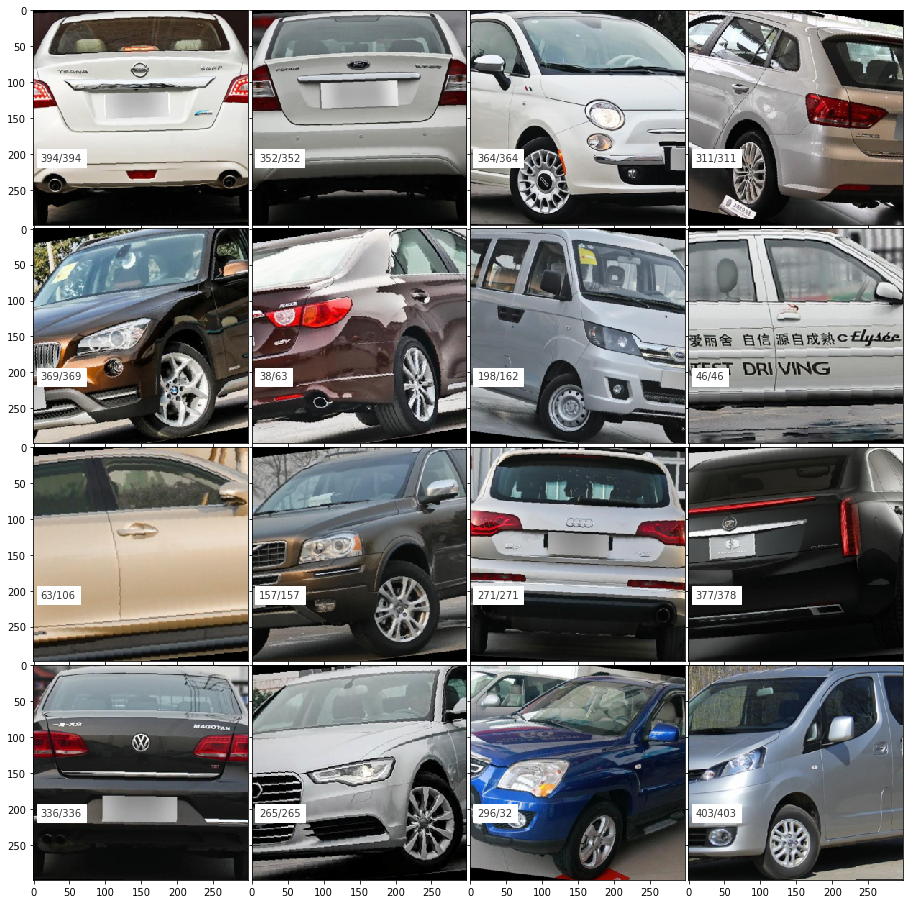

In [10]:
### Display some predictions based on above model
###

# traindataiter = iter(trainloader)
# images, labels = traindataiter.next()
# fig = plt.figure(figsize=(16, 8))
# imshow2(images, labels, 16)

from mpl_toolkits.axes_grid1 import ImageGrid

def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    model.train(False)
    
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])       
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]),
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

            
visualize_model(dloaders, net)

In [163]:
###########################################
###### convert make and model to csvs
###########################################

make_names = make_model_name['make_names']
make_size = make_names.size
make_csv_file = 'make_names.csv'
make_csv = os.path.join(miscPath, make_csv_file)

f = open(make_csv,'w')
for i in range(0, make_names.size):
    line = '%d, %s' % (i + 1, make_names[i][0][0]) + '\n'
    f.write(line)
f.close()


model_names = make_model_name['model_names']
model_size = model_names.size
modle_csv_file = 'modle_names.csv'
modle_csv = os.path.join(miscPath, modle_csv_file)

f = open(modle_csv,'w')
for i in range(0, model_size):
    if model_names[i][0] : model = model_names[i][0][0]
    else: model = "TBD"
    
    line = '%d, %s' % (i + 1, model) + '\n'
    f.write(line)
f.close()

In [88]:
###########################################
###### convert car_type to csv
###########################################

car_type['types']

car_type_names = car_type['types'][0]

car_type_csv_file = 'car_type.csv'
car_type_csv = os.path.join(miscPath, car_type_csv_file)

f = open(car_type_csv,'w')
for i in range(0, car_type_names.size):
    line = '%d, %s' % (i + 1, car_type_names[i][0]) + '\n'
    f.write(line)
f.close()